<a href="https://colab.research.google.com/github/freedom-780/Psychedelic-mushrooms/blob/main/Psychedelic_mushrooms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd 
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline


In [7]:
#Import data from github
data = "https://raw.githubusercontent.com/freedom-780/Psychedelic-mushrooms/main/AHRI_DATASET_PM_MANUSCRIPT_DATA.csv"
p_mush_df = pd.read_csv(data)

In [8]:
p_mush_df.shape

(7139, 57)

In [9]:
# copy dataframe for analysis to preserve original dataframe
df = p_mush_df.copy()

In [10]:
# Set index to case ID since every caseID is Unique
df.set_index('CASEID_7139', inplace=True)

In [11]:
df.columns

Index(['COHORTS', 'PYS_USE_VENN', 'PSY_USE_YN', 'PM_USE_YN', 'PM_USE_ONLY_YN',
       'PM_VS_PSY_YN', 'SEX', 'AGE', 'ETHNICITY', 'HLS_YN', 'REGION', 'ED',
       'EMPL', 'INCOME', 'BMI', 'C_TOTAL', 'C_DP', 'C_ANX', 'C_PN', 'C_ALL',
       'C_MI', 'C_INSOM', 'C_HYP', 'C_DH', 'C_SA', 'C_GERD', 'C_CS', 'C_LIP',
       'CCI_SCORE', 'GAD7_SCORE', 'PHQ9_SCORE', 'GAD7_GE10', 'PHQ9_GE10',
       'PCS12', 'MCS12', 'VR6D', 'RU_PCP_YN', 'RU_SPECIAL_YN', 'RU_OTPCP_YN',
       'RU_UCC_YN', 'RU_OUTPT_YN', 'RU_ER_YN', 'RU_HSP_YN',
       'PSY1_POSITIVE_USE', 'PSY2_GEN_HEALTH', 'PSY2_DIAG_CONDITION',
       'PSY2_UNDIAG_CONCERN', 'PSY2_NO_KNOWLEDGE', 'PM1_GEN_HEALTH',
       'PM1_DIAG_CONDITION', 'PM1_UNDIAG_CONCERN', 'PM2_FREQ_COVID',
       'PM3_FREQ_POLITICS', 'PM4_CARE', 'INSURANCE', 'DATA_WEIGHT'],
      dtype='object')

Not interested in all columns the goal is to predict the Rand classification score based on psychedelic use and other relevant health features or to predict psychedelic use based on features

In [12]:
# make a list of columns to keep

columns_keep = ['COHORTS', 'PYS_USE_VENN', 'PSY_USE_YN', 'PM_USE_YN', 'PM_USE_ONLY_YN', 'PM_VS_PSY_YN', 'SEX', 'AGE', 'ETHNICITY', 'HLS_YN', 'REGION',  \
                 'ED', 'EMPL', 'INCOME', 'BMI', 'GAD7_SCORE', 'PHQ9_SCORE']

This dataset has 57 columns initially, most of these were dropped, trying to predict the PHQ9 score(ranges from 0-27) that has different ranges for different severity of depression. Those rows that were dropped have to do with hostipals stays, previous conditions of the patient, etc. while these might be useful to the model, only the qualities of the patient and psychedelics use is of interest.

In [13]:
df.drop(df.columns.difference(columns_keep), 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [14]:
df.head().T

CASEID_7139,1,2,3,4,5
COHORTS,1.00,1.00,1.00,1.00,1.00
PYS_USE_VENN,1.00,1.00,1.00,1.00,1.00
PSY_USE_YN,1.00,1.00,1.00,1.00,1.00
PM_USE_YN,1.00,1.00,1.00,1.00,1.00
PM_USE_ONLY_YN,1.00,1.00,1.00,1.00,1.00
PM_VS_PSY_YN,2.00,2.00,2.00,2.00,2.00
SEX,0.00,0.00,0.00,0.00,0.00
AGE,19.00,21.00,22.00,22.00,23.00
ETHNICITY,3.00,2.00,2.00,2.00,2.00
HLS_YN,1.00,0.00,0.00,0.00,0.00


In [15]:
df.describe()

,COHORTS,PYS_USE_VENN,PSY_USE_YN,PM_USE_YN,PM_USE_ONLY_YN,PM_VS_PSY_YN,SEX,AGE,ETHNICITY,HLS_YN,REGION,ED,EMPL,INCOME,BMI,GAD7_SCORE,PHQ9_SCORE
count,"7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00"
mean,-5.59,0.17,0.07,0.04,0.02,-91.60,0.46,46.15,1.95,0.08,2.63,0.73,0.30,"64,563.71",28.02,6.33,7.33
std,22.88,0.64,0.26,0.19,0.13,26.25,0.50,16.65,0.51,0.27,1.00,0.45,0.46,"26,258.63",7.25,5.89,6.99
min,-99.00,0.00,0.00,0.00,0.00,-99.00,0.00,18.00,1.00,0.00,1.00,0.00,0.00,"9,076.00",11.16,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,-99.00,0.00,33.00,2.00,0.00,2.00,0.00,0.00,"46,322.50",23.05,1.00,1.00
50%,0.00,0.00,0.00,0.00,0.00,-99.00,0.00,43.00,2.00,0.00,3.00,1.00,0.00,"58,129.00",26.58,5.00,5.00
75%,0.00,0.00,0.00,0.00,0.00,-99.00,1.00,60.00,2.00,0.00,3.00,1.00,1.00,"77,263.00",31.41,10.00,12.00
max,1.00,3.00,1.00,1.00,1.00,2.00,1.00,95.00,3.00,1.00,4.00,1.00,1.00,"237,841.00",73.12,21.00,27.00


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7139 entries, 1 to 7139
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   COHORTS         7139 non-null   float64
 1   PYS_USE_VENN    7139 non-null   float64
 2   PSY_USE_YN      7139 non-null   float64
 3   PM_USE_YN       7139 non-null   float64
 4   PM_USE_ONLY_YN  7139 non-null   float64
 5   PM_VS_PSY_YN    7139 non-null   float64
 6   SEX             7139 non-null   int64  
 7   AGE             7139 non-null   float64
 8   ETHNICITY       7139 non-null   float64
 9   HLS_YN          7139 non-null   float64
 10  REGION          7139 non-null   float64
 11  ED              7139 non-null   float64
 12  EMPL            7139 non-null   float64
 13  INCOME          7139 non-null   int64  
 14  BMI             7139 non-null   float64
 15  GAD7_SCORE      7139 non-null   float64
 16  PHQ9_SCORE      7139 non-null   float64
dtypes: float64(15), int64(2)
memory u

In [17]:
df['COHORTS'].value_counts()

0.00      6613
-99.00     404
1.00       122
Name: COHORTS, dtype: int64

In [18]:
df['PM_USE_ONLY_YN'].value_counts()

0.00    7017
1.00     122
Name: PM_USE_ONLY_YN, dtype: int64

In [19]:
df['PM_VS_PSY_YN'].value_counts()

-99.00    6613
1.00       270
2.00       256
Name: PM_VS_PSY_YN, dtype: int64

In [20]:
df['PSY_USE_YN'].value_counts()

0.00    6613
1.00     526
Name: PSY_USE_YN, dtype: int64

The dataset seems to be unbalanced with more 0 than 1s if we were going to classify psychedelics use. Even though predicting psychedelic use based on the other features, a more interesting question is predicting the depression score based on the other features. This way you can have some idea of their beanift 

In [21]:
df.describe()

,COHORTS,PYS_USE_VENN,PSY_USE_YN,PM_USE_YN,PM_USE_ONLY_YN,PM_VS_PSY_YN,SEX,AGE,ETHNICITY,HLS_YN,REGION,ED,EMPL,INCOME,BMI,GAD7_SCORE,PHQ9_SCORE
count,"7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00","7,139.00"
mean,-5.59,0.17,0.07,0.04,0.02,-91.60,0.46,46.15,1.95,0.08,2.63,0.73,0.30,"64,563.71",28.02,6.33,7.33
std,22.88,0.64,0.26,0.19,0.13,26.25,0.50,16.65,0.51,0.27,1.00,0.45,0.46,"26,258.63",7.25,5.89,6.99
min,-99.00,0.00,0.00,0.00,0.00,-99.00,0.00,18.00,1.00,0.00,1.00,0.00,0.00,"9,076.00",11.16,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,-99.00,0.00,33.00,2.00,0.00,2.00,0.00,0.00,"46,322.50",23.05,1.00,1.00
50%,0.00,0.00,0.00,0.00,0.00,-99.00,0.00,43.00,2.00,0.00,3.00,1.00,0.00,"58,129.00",26.58,5.00,5.00
75%,0.00,0.00,0.00,0.00,0.00,-99.00,1.00,60.00,2.00,0.00,3.00,1.00,1.00,"77,263.00",31.41,10.00,12.00
max,1.00,3.00,1.00,1.00,1.00,2.00,1.00,95.00,3.00,1.00,4.00,1.00,1.00,"237,841.00",73.12,21.00,27.00


In [22]:

print(f"Shape data: {p_mush_df.shape}")
print(f"Number of mission values in data: \
{p_mush_df.isnull().sum().sum()}")
print(f"Number of duplicate values in data: \
{p_mush_df.duplicated().sum()}")

Shape data: (7139, 57)
Number of mission values in data: 0
Number of duplicate values in data: 0


In [23]:
df.nunique()

COHORTS              3
PYS_USE_VENN         4
PSY_USE_YN           2
PM_USE_YN            2
PM_USE_ONLY_YN       2
PM_VS_PSY_YN         3
SEX                  2
AGE                 76
ETHNICITY            3
HLS_YN               2
REGION               4
ED                   2
EMPL                 2
INCOME            4890
BMI               1551
GAD7_SCORE          22
PHQ9_SCORE          28
dtype: int64

<Figure size 1080x1080 with 0 Axes>

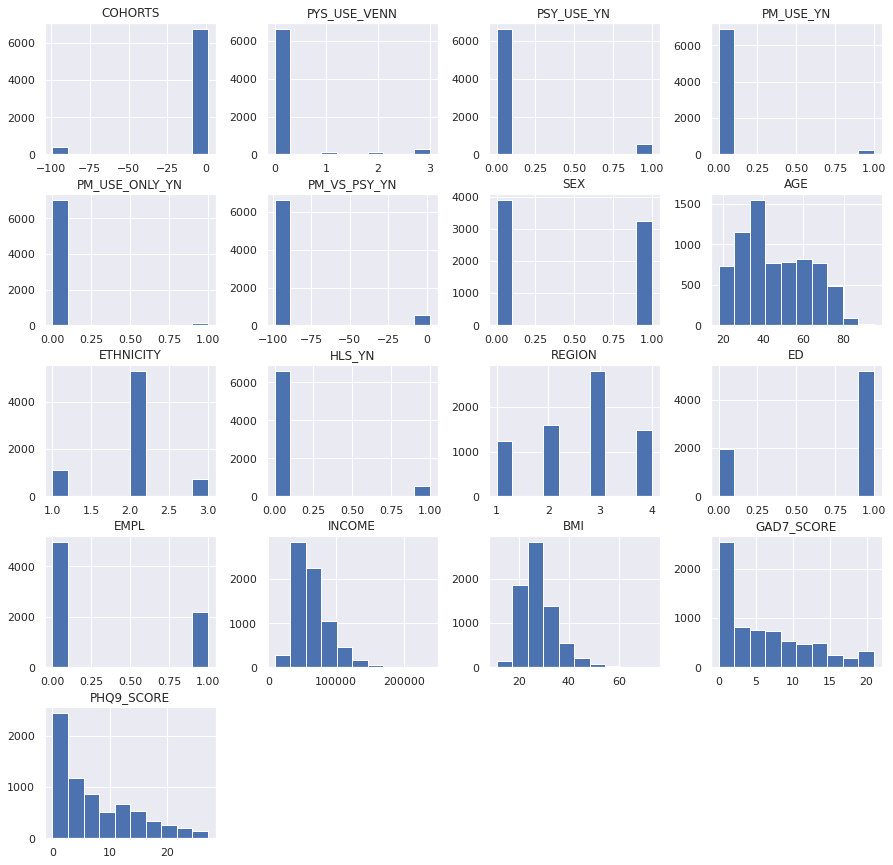

In [24]:
sns.set(rc = {'figure.figsize':(15,15)})
plt.tight_layout()
df.hist();

Most of the data seems to be shewed with left tails, may need to do transformations on the data 

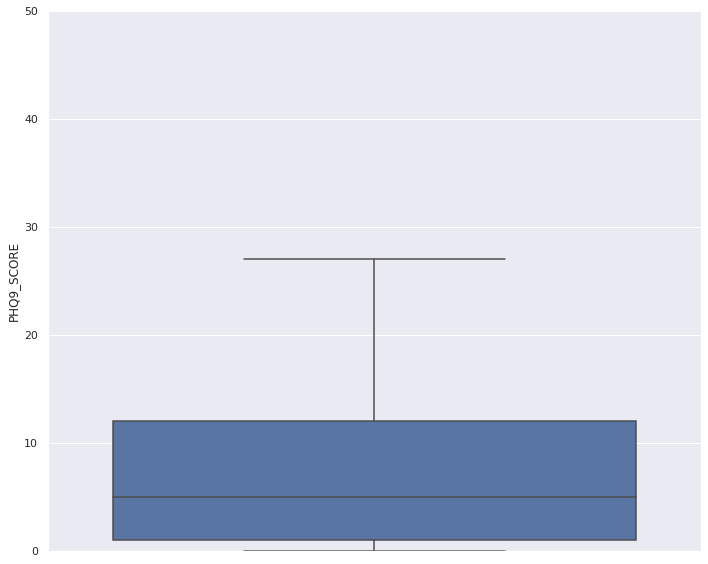

In [28]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.boxplot(y ='PHQ9_SCORE',data=df)
plt.ylim(0, 50)
plt.tight_layout()

seems there are no outliers for the dependent vaiable